# Ice sheets
Measuring ice-sheet changes can be quite challenging because of the remote locations of Greenland and Antarctica. Different sources of measurement (laser, gravimetry, radar) show different results. This notebook shows the results of what's referred to as a "reconciled" estimate. The IMBIE group set it as a goal to [create](http://dx.doi.org/10.1126/science.1228102) an estimate that combines the different measurements into one estimate with a narrower confidence band. Creating an estimate based on a series of independent studies is referred to as a meta-analysis. Meta-analysis have been [popular](https://smw.ch/article/doi/smw.2012.13518) in medical research. 
Since the study of 2012, several updates have been published. This notebook is based on the 2018 Antarctic Dataset  and the 2019 version of the Greenland dataset. Because several studies are combined this indicator is typically lagging in time.

In [2]:
# builtins
import pathlib
import datetime

# extra modules
import pandas as pd
import matplotlib.pyplot as plt
# earthengine-api
import ee

%matplotlib inline

In [3]:
# The datasets are provided in excel files
path = pathlib.Path('~/src/sealevel/data/imbie/imbie_dataset-2018_07_23.xlsx').expanduser()
# Make sure you have xlrd  installed
sheets = pd.read_excel(path, sheet_name=None)
dfs = []
for name, df in sheets.items():
    df['location'] = name
    dfs.append(df)
antarctica_df = pd.concat(dfs)

In [6]:
# The last measurements are typically months to a year behind
# More realtime data can be obtained from GRACE-FO (gravimetry) and Sentinel-1 (radar)
antarctica_df.tail()

,Year,Cumulative ice mass change (Gt),Cumulative ice mass change uncertainty (Gt),Cumulative sea level contribution (mm),Cumulative sea level contribution uncertainty (mm),location
301,2017.083333,-2278.253510,259.098216,6.328482,0.719717,West Antarctica
302,2017.166667,-2289.743927,258.935756,6.360400,0.719266,West Antarctica
303,2017.250000,-2301.234344,258.774541,6.392318,0.718818,West Antarctica
304,2017.333333,-2312.724760,258.614561,6.424235,0.718374,West Antarctica
305,2017.416667,-2324.215177,258.455804,6.456153,0.717933,West Antarctica


In [22]:
# the dataset from Greenland is somewhat different. Exact naming (casing, spacing, etc..) might change from version to version
path = pathlib.Path('~/src/sealevel/data/imbie/imbie_dataset_greenland_dynamics-2020_02_28.xlsx').expanduser()

sheets = pd.read_excel(path, sheet_name=None)
dfs = []
for name, df in sheets.items():
    df['location'] = name
    dfs.append(df)
greenland_df = pd.concat(dfs)
set(greenland_df.location)

{'Greenland Equivalent Sea Level', 'Greenland Ice Mass'}

In [29]:
greenland_df.tail()


,Year,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice sheet mass change uncertainty (Gt),Rate of mass balance anomaly (Gt/yr),Rate of mass balance anomaly uncertainty (Gt/yr),Cumulative surface mass balance anomaly (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Rate of ice dynamics anomaly (Gt/yr),...,Cumulative ice sheet mass change (mm sea level),Cumulative ice sheet mass change uncertainty (mm sea level),Rate of mass balance anomaly uncertainty (mm sea level/yr),Cumulative surface mass balance anomaly (mm sea level/yr),Cumulative surface mass balance anomaly (mm sea level),Cumulative surface mass balance anomaly uncertainty (mm sea level),Rate of ice dynamics anomaly (mm sea level/yr),Rate of ice dyanamics anomaly uncertainty (mm sea level/yr),Cumulative ice dynamics anomaly (mm sea level),Cumulative ice dynamics anomaly uncertainty (mm sea level)
463,2018.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.088516,0.957967,-0.126814,0.213977,5.448477,1.394187,0.526259,0.265857,5.718848,1.519670
464,2018.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.121803,0.959049,-0.126814,0.213977,5.437910,1.395555,0.526259,0.265857,5.762703,1.521607
465,2018.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.155090,0.960130,-0.126814,0.213977,5.427342,1.396921,0.526259,0.265857,5.806558,1.523541
466,2018.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.188377,0.961209,-0.126814,0.213977,5.416774,1.398286,0.526259,0.265857,5.850412,1.525473
467,2018.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.221664,0.962288,-0.126814,0.213977,5.406206,1.399650,0.526259,0.265857,5.894267,1.527402


## Combining both datasets
The datasets typically contain one source 

In [23]:
antarctica_selected = antarctica_df[antarctica_df.location=='Antarctica']
antarctica_slr = antarctica_selected['Cumulative sea level contribution (mm)']
antarctica_ci = antarctica_selected['Cumulative sea level contribution uncertainty (mm)']

greenland_selected = greenland_df[greenland_df.location == 'Greenland Equivalent Sea Level']
greenland_slr = greenland_selected['Cumulative ice sheet mass change (mm sea level)']
greenland_ci = greenland_selected['Cumulative ice sheet mass change uncertainty (mm sea level)']


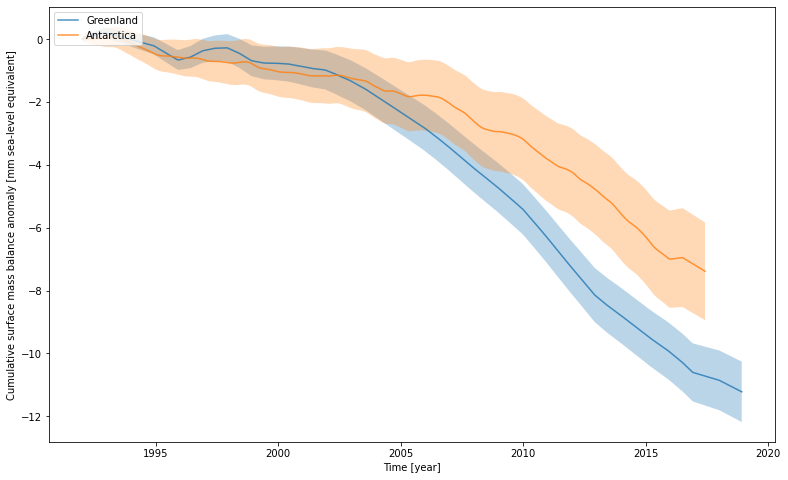

In [27]:
fig, ax = plt.subplots(figsize=(13, 8))
# All losses are positive (mm sea-level equivalent rise)
# So we multiply everything with -1
ax.fill_between(greenland_selected['Year'], -greenland_slr + greenland_ci, -greenland_slr - greenland_ci, alpha=0.3)
ax.plot(greenland_selected['Year'], -greenland_slr, alpha=0.8, label='Greenland')
ax.fill_between(antarctica_selected['Year'], -antarctica_slr + antarctica_ci, -antarctica_slr - antarctica_ci, alpha=0.3)
ax.plot(antarctica_selected['Year'], -antarctica_slr, alpha=0.8, label='Antarctica')
ax.set_ylabel('Cumulative surface mass balance anomaly [mm sea-level equivalent]')
ax.set_xlabel('Time [year]')
ax.legend(loc='upper left');


# Mass change
<div style="display: flex;">
<div>
One of the sources of the IMBIE study that we will at in more detail are the gravimetric measurements from  the GRACE mission and the <a href="https://gracefo.jpl.nasa.gov">GRACE-FO</a> mission. Each mission consists of a twin pair of satellites. The satellites "fall" over the gravity field of the earth and measuring the distance between the two satellites. When gravity is higher the first satellite falls faster increasing their distance. If gravity decreases the inter-satellite distance increases. 
    
The observed changes in gravity are caused by changes in mass. Most of these gravity changes are caused by changes in the water balance. Another source are changes in the viscose core of the earth is also changing, for example <a href="https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2005EO390002">due</a> to the tsunami near Aceh. Because water changes make up the largest component, changes are expressed in centimeters of equivalent water thickness.
</div>
<div>
<img src="https://gracefo.jpl.nasa.gov/internal_resources/89"  style="max-width: 300px; margin-left: 10px">
</div>
</div>

In [31]:
# Initalize Google Earth Engine
ee.Initialize()

In [38]:
# The GRACE dataset
grace_land = ee.ImageCollection("NASA/GRACE/MASS_GRIDS/LAND")

# Two polygons that cover Antarctica and Greenland
# Antarctica is split into pieces because it crosses the pole and is otherwise undefined
antarctica = ee.Geometry.MultiPolygon(
        [[[[-180, -58],
           [-180, -90],
           [0, -90],
           [0, -58]]],
         [[[0, -58],
           [0, -90],
           [180, -90],
           [180, -58]]]], None, True)
greenland = ee.Geometry.Polygon(
        [[[-72.43977570253338, 79.32383883021862],
          [-74.3640680845993, 77.69407430076578],
          [-69.11465536077975, 74.87884333546832],
          [-59.598443084599296, 73.07548797936632],
          [-57.489068084599296, 63.93985411420621],
          [-44.832818084599296, 57.043802821920835],
          [-36.395318084599296, 62.99772320136553],
          [-29.012505584599296, 66.72477348126094],
          [-19.52031808459924, 68.97619016554378],
          [-15.30156808459924, 72.02147236458458],
          [-14.59844308459924, 76.80202844978761],
          [-9.32500558459924, 80.20961277723778],
          [-10.02813058459924, 82.0950195376816],
          [-18.11406808459924, 82.47256887158471],
          [-24.09063058459924, 83.65817793891526],
          [-37.450005584599296, 83.8116325974187],
          [-53.973443084599296, 82.96259008242481],
          [-66.9812555845993, 80.84580010699196]]])

In [65]:
def mean(i, geometry):
    # compute  mean for geometry
    mean = i.reduceRegion(
      reducer=ee.Reducer.mean(),
      geometry=geometry, 
      scale=10000, 
      crs='EPSG:4326',
      maxPixels=5e9
    )
    # add time
    mean = mean.set('t', i.get('system:time_start'))
    result = ee.Feature(None, mean)
    return result

# Compute the mass change across  Antarctica and Greenland
result_antarctica = grace_land.map(lambda i: mean(i, antarctica)).getInfo()
result_greenland = grace_land.map(lambda i: mean(i, greenland)).getInfo()

In [40]:
for feature in result_antarctica['features']:
    feature['properties']['date'] = datetime.datetime.fromtimestamp(feature['properties']['t'] / 1000)
    feature['properties']['location'] = 'Antarctica'
for feature in result_greenland['features']:
    feature['properties']['date'] = datetime.datetime.fromtimestamp(feature['properties']['t'] / 1000)
    feature['properties']['location'] = 'Greenland'

In [41]:
grace_df = pd.concat([
    pd.DataFrame(x['properties'] for x in result_antarctica['features']),
    pd.DataFrame(x['properties'] for x in result_greenland['features'])
])

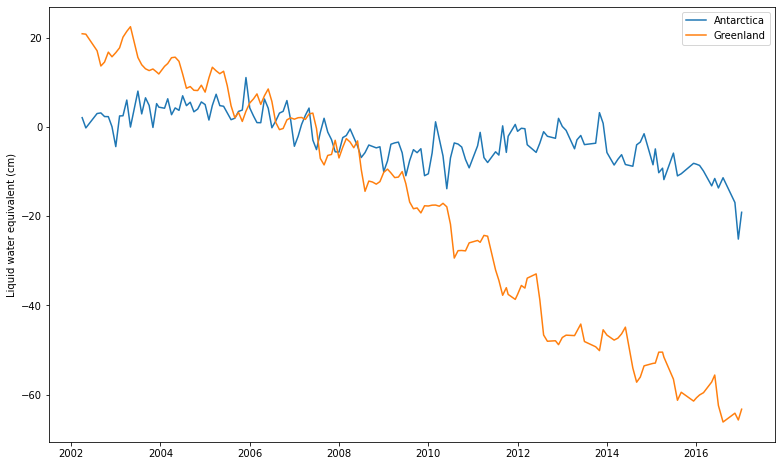

In [66]:
fig, ax = plt.subplots(figsize=(13, 8))

for location, df in grace_df.groupby('location'):
    df = df.sort_values('date')
    ax.plot(df['date'], df['lwe_thickness_jpl'], label=location)
ax.set_ylabel('Liquid water equivalent (cm)')
ax.legend()

91